[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/worm_synergy/blob/master/notebooks/model_exploration.ipynb)

# SynergyGT (Synergy Graph Transformer) Model Exploration
This notebook serves as an interactive tool for investigating specific genes and gene pairs (double mutants) using a pre-trained SynergyGT model. It allows users to get predictions for any arbitrary pair, infer a gene's most synergistic partners, and use the model to recommend new experiments via Bayesian Optimization or Active Learning.

Run the cells below in order.

In [ ]:
!GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/Bradley-Buchner/worm_synergy.git
!pip install torch-geometric torchmetrics

In [ ]:
# --- Download data from Google Drive ---
import os

def download_from_drive(file_id, destination):
    !gdown --fuzzy "https://drive.google.com/file/d/{file_id}/view" -O {destination}

files = {
    "worm_synergy/data/demo_model.pth": "1b3VpUJvyn3t3-RgpENF8834Y9jUEzN2n",
    "worm_synergy/data/worm_synergy_pyg_data_demo_raw.pt": "1jR2XYanZ7yVsDOOkt8VPWs_aFOuIB-1G",
    "worm_synergy/data/worm_synergy_pyg_data_demo_processed.pt": "1z6Ge9RWYFDAgkc5bbhl5U_2P577scZNq",
    "worm_synergy/data/perturbation2idx.pkl": "1XPQD7XvbkB9jUNMKhHZq9vhCUY_QcdhV",
    "worm_synergy/data/node2id.pkl": "13BstNC-6Y3jsjTP4YlDA8V38w3xNTow5",
    "worm_synergy/data/id2node.pkl": "1jLz21BoPU7V0cFuh3ScEAmno6MO5Nesd",
    "worm_synergy/data/synergy_gt_subgraphs.pt": "1Xy-4Wop2Min6JjD-I-yX4Em-vbLhzcS0",
    "worm_synergy/data/final_synergy_gt_model_state_dict_122825_8d_6l.pth": "1C7EOkKkOJO4uv_7QYvOZQD4ef-BcpmJL",
    "worm_synergy/data/graph_transformer/avg_path_sum_matrix.pt": "1WdQ7V7PA3tt6KYmb3w20nUQLZL8xPd4f",
    "worm_synergy/data/graph_transformer/spd_matrix.pt": "13ojb3dNKBail_154cqiCqQfAqQZ9OOrn",
    "worm_synergy/data/graph_transformer/in_degree.pt": "1ngDk6JfFTNAopBjXDs-FUeI5wq34X92j",
    "worm_synergy/data/graph_transformer/out_degree.pt": "10R9mFGtZu31vbLnkmLhjU5KabQSzu6Og",

}

for path, file_id in files.items():
    print(f"Checking {path}...")

    if not os.path.exists(path) or os.path.getsize(path) < 1024:
        print(f"Downloading real data for {path} from Google Drive...")
        download_from_drive(file_id, path)
    else:
        print(f"Real data already present for {path}.")

In [ ]:
# change wd to '/content/worm_synergy'
print(os.getcwd())
os.chdir('worm_synergy')
print(os.getcwd())

In [5]:
import pickle
import importlib

import model
from model.preprocessing import *
from model.models import *
from model.utils import *

importlib.reload(model.preprocessing)
importlib.reload(model.models)
importlib.reload(model.utils)


<module 'model.utils' from '/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/utils.py'>

## Load processed data and pre-trained model

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

data = torch.load('data/worm_synergy_pyg_data_demo_processed.pt', map_location=device, weights_only=False)
data.to(device)

with open("data/perturbation2idx.pkl", "rb") as f:
    perturbation2idx = pickle.load(f)

with open("data/node2id.pkl", 'rb') as f:
    node2id = pickle.load(f)

with open("data/id2node.pkl", 'rb') as f:
    id2node = pickle.load(f)

subgraph_data = torch.load('data/synergy_gt_subgraphs.pt', map_location=device, weights_only=False)

out_degree = degree(data.edge_index[0], num_nodes=data.num_nodes)
in_degree = degree(data.edge_index[1], num_nodes=data.num_nodes)
max_degree = torch.max(torch.cat([in_degree, out_degree], dim=0)).item()

spd_filepath = "data/graph_transformer/spd_matrix.pt"
spd_tensor = torch.load(spd_filepath, weights_only=False)

params = {
    'max_spd': spd_tensor.max().item(),
    'num_degree_bins': 5,
    'dropout_p': 0.1,
    'd_model': 8,
    'num_heads': 2,
    'num_layers': 6
}

model_loaded = SynergyGT(
    graph_data=data,
    params=params
).to(device)
model_loaded.load_state_dict(torch.load('data/final_synergy_gt_model_state_dict_122825_8d_6l.pth', map_location=device, weights_only=False))
model_loaded.eval()
print("--- Loaded Model Architecture ---")
print(model_loaded)

## Pair exploration
This section enables a deep-dive into the interaction between any two specific genes. Rather than looking at genes in isolation, SynergyGT extracts a one-hop local subgraph—the focal genes and their immediate neighbors—to capture the functional context of their interaction. For any pair of genes, this section will:
* Get predicted likelihoods for Antagonistic, Additive, and Synergistic interactions.
* Compute uncertainty estimates that reflect the model's prediction confidence.
* Summarize the local subgraph used to make the prediction.

Change the `gene_u` and `gene_v` variables below to investigate different pairs

In [3]:
# @title { display-mode: "form" }
# @markdown Enter gene names for pair exploration:
gene_u = "age-1" # @param {type:"string"}
gene_v = "rsks-1" # @param {type:"string"}

# @markdown ---

In [4]:
gene_u_id = node2id[gene_u]
gene_v_id = node2id[gene_v]
inference_pairs = [(gene_u_id, gene_v_id)]

pre_configs = {
    'max_spd': spd_tensor.max().item(),
    'max_dist_uv': spd_tensor.max().item(),
    'k_hop': 1,
    'sampling_mode': 'union',
    'target_subgraph_size': 0,
    'max_in_degree': max_degree,
    'max_out_degree': max_degree,
    'num_degree_bins': 5,
    'attributes_dir': 'data/graph_transformer',
    'output_path': None,
    'device': device
}

pert_a_max = data.pair_pert_group_index[1].max().item()
pert_b_max = data.pair_pert_group_index[3].max().item()
pert_padding = max(pert_a_max, pert_b_max) + 1
collate_fn_configs = {
    'node_ids': data.num_nodes,
    'node_perturbations': pert_padding,
    'in_degree': max_degree + 1,
    'out_degree': max_degree + 1,
    'dist_to_u': spd_tensor.max().item() + 1,
    'dist_to_v': spd_tensor.max().item() + 1,
    'pairwise_dist': spd_tensor.max().item() + 1,
    'adj_matrix': data.edge_type.max().item() + 1,
    'average_edge_type_encoding': data.edge_type.max().item() + 1,
    'lifespan_dist': data.lifespan_dist.max().item() + 1
}

inference_loader, inference_subgraph = get_loader_inference(data, inference_pairs, preprocessor_fn=generate_subgraph_samples, preprocessor_fn_configs=pre_configs, dataset_cls=PairSubgraphDataset, collate_fn=graphormer_collate_fn, collate_fn_configs=collate_fn_configs, batch_size=32)

NameError: name 'node2id' is not defined

### Gene-pair predictions and subgraph

We use Monte Carlo (MC) Dropout via `predict_with_mc_dropout` to generate a distribution of predictions rather than a single value. By running the model multiple times with dropout enabled, we can approximate Bayesian inference and measure the uncertainty of predictions.

*Note: predictions are made using the most common perturbation combination: gene U knockdown + gene V knockout*

MC Dropout Sampling: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


--- Antagonistic Interaction Statistics ---
MAP Estimate: 0.2433
95% CI:       [0.2275, 0.2793]
Mean (μ):     0.2481

--- Additive Interaction Statistics ---
MAP Estimate: 0.3540
95% CI:       [0.2994, 0.4493]
Mean (μ):     0.3675

--- Synergistic Interaction Statistics ---
MAP Estimate: 0.3930
95% CI:       [0.3113, 0.4527]
Mean (μ):     0.3844



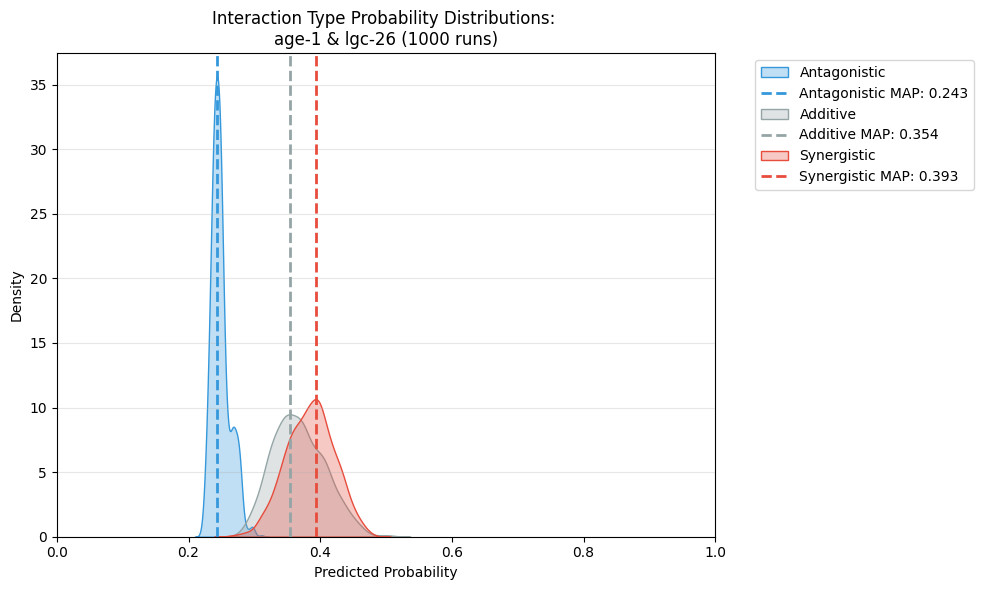

In [5]:
# Get a distribution of predictions for the gene pair using MC dropout sampling
samples = 1000
results, _ = predict_with_mc_dropout(model_loaded, inference_loader, num_samples=samples, device=device)

# Visualize results for the first pair in the loader
plot_uncertainty_densities(results[0], pair_name=f"\n{gene_u} & {gene_v} ({samples} runs)")

Visualize the local network that the model "saw" to make its decision. This provides the model with an idea of local topology, interaction types, and positioning of aging-related genes.

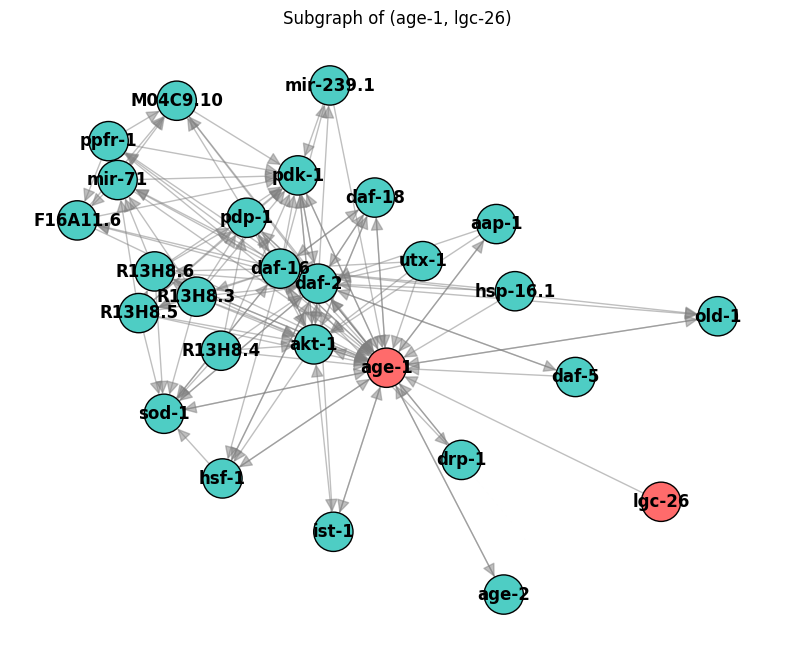

=== Subgraph Summary (age-1 & lgc-26) ===

Hop distance between nodes: 1   (1 => nodes interact directly)

Aging distance (lifespan_dist) - Gene U: 0, Gene V: 0   (0 => is a known lifespan gene, 1 => interacts with a known lifespan gene)

=== Subgraph Edge Summary ===
Total interactions/edges: 135
- Genetic (Type 0): 89 (65.9%)
- Regulatory (Type 1): 40 (29.6%)
- Physical (Type 2): 6 (4.4%)


In [6]:
# Plot the subgraph for the gene pair of interest
plot_subgraph_sample(inference_subgraph, data, id2node_dict=id2node)

# Get summary statistics for the pair's subgraph
analyze_subgraph_sample(inference_subgraph, id2node_dict=id2node)

## Single-gene exploration
Characterize a single gene by scanning its interactions across the full network. For any chosen gene, this section will:

- Summarize its local network context (neighbors, degrees, edge types).
- Surface any available experimental evidence from SynergyAge.
- Estimate the distribution of interaction outcomes (Antagonistic, Additive, Synergistic) by pairing the gene with all other nodes and aggregating predictions.
- Rank and display the most promising synergistic partners to guide follow-up experiments.

Set gene_name to the gene of interest before running the cells below.


### Single-gene data summary
Generate a summary of a specified gene's connectivity in the interaction network, its relationship types, and its association with aging.

In [ ]:
# @title { display-mode: "form" }
# @markdown Enter gene name for single-gene exploration:
gene_name = "age-1" # @param {type:"string"}

# @markdown ---

In [7]:
gene_id = node2id[gene_name]

single_gene_summary(gene_id, data, id2node)

=== Summary for Gene: lgc-26 (ID: 10522) ===
- Centrality: In-Degree = 0.0, Out-Degree = 2.0
- Interaction Types (Total: 2):
  * Genetic:    2 (100.0%)
  * Regulatory: 0 (0.0%)
  * Physical:   0 (0.0%)
- Known Lifespan Association: YES
- Neighbors: 2 unique neighbors, 2 are lifespan genes
- Appears in Experimental Data: No


### Single-gene model predictions
The function `single_gene_predictions` pairs the gene of interest with every other node in the network and runs an inference pass. This provides a global view of a gene's synergistic potential in the context of lifespan regulation, and reveals a gene's most likely synergistic partners.

In [8]:
# Get all partners and build list of pair tuples
all_inference_pairs = []
for id in list(id2node.keys()):
    if id != gene_id:
        tuple = (gene_id, id)
        all_inference_pairs.append(tuple)

all_inference_loader, all_inference_subgraphs = get_loader_inference(data, all_inference_pairs, preprocessor_fn=generate_subgraph_samples, preprocessor_fn_configs=pre_configs, dataset_cls=PairSubgraphDataset, collate_fn=graphormer_collate_fn, collate_fn_configs=collate_fn_configs, batch_size=16)



--- Initializing Inference for 11492 Pair(s) ---
--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 11492 pairs...


Building Subgraphs: 100%|██████████| 11492/11492 [00:20<00:00, 559.75it/s]

--- Pre-processing finished successfully! Returning 11492 samples. ---


In [14]:
# Get predictions for all possible pairs including the gene of interest
predictions = get_predictions_synergy_model(model_loaded, all_inference_loader, label_name=None, device=device)

# Summarize predictions for the gene of interest
single_gene_predictions(predictions, id2node, gene_id, top_n=10)

Eval: 100%|██████████| 360/360 [00:17<00:00, 20.94it/s] 

=== Model Predictions for Gene: lgc-26 (ID: 10522) ===
- Evaluation Details:
  * Total Pairs Evaluated: 11492
  * Avg. Predicted Distribution [Antag / Addit / Synerg]:
    [0.245 / 0.332 / 0.423]

  * Top 10 most synergistic double mutants:
    Mutant                                        | Synergistic Prob.   
    ----------------------------------------------------------------------
    lgc-26(kd) + exl-1(ko)                        | 0.498
    lgc-26(kd) + ragc-1(ko)                       | 0.497
    lgc-26(kd) + F44F4.3(ko)                      | 0.497
    lgc-26(kd) + T05E7.1(ko)                      | 0.497
    lgc-26(kd) + Y65B4A.7(ko)                     | 0.497
    lgc-26(kd) + sus-1(ko)                        | 0.497
    lgc-26(kd) + F11G11.13(ko)                    | 0.497
    lgc-26(kd) + cdh-7(ko)                        | 0.497
    lgc-26(kd) + nmy-3(ko)                        | 0.497
    lgc-26(kd) + ile-2(ko)                        | 0.497


## Open exploration
Use the trained SynergyGT model as a recommendation engine to propose new double-mutant experiments.

What this section does:
- Builds a pool of untested gene pairs (open experiments).
- Scores that pool with the model using MC Dropout for uncertainty.
- Selects pairs with either:
  - Bayesian Optimization (UCB): prioritize high predicted synergy (exploitation).
  - Active Learning (BALD): prioritize highest uncertainty to improve the model (exploration).

Tips:
- Keep the pool size and MC samples modest to control runtime.
- Adjust `query_size` to set how many candidate experiments to return.


In [42]:
# Sample a list of gene pairs that we don't have data on (have an unknown experimental outcome)
open_exp_pairs = get_unknown_gene_pairs(data, sampling_pool_node_ids=data.node_index.cpu().tolist(),
                                       N_pool_pairs=100, pool_strategy="both_aging", min_mutual_interactors=0)

open_exp_loader, open_exp_subgraph_data = get_loader_inference(data, open_exp_pairs, preprocessor_fn=generate_subgraph_samples, preprocessor_fn_configs=pre_configs, dataset_cls=PairSubgraphDataset, collate_fn=graphormer_collate_fn, collate_fn_configs=collate_fn_configs, batch_size=32)


--- Initializing Inference for 100 Pair(s) ---
--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 100 pairs...


Building Subgraphs: 100%|██████████| 100/100 [00:00<00:00, 384.15it/s]

--- Pre-processing finished successfully! Returning 100 samples. ---


### Bayesian Optimization
**Goal:** Prioritize untested double mutants most likely to exhibit high synergy.

**Strategy:** Unlike Active Learning’s pure exploration, this is an exploitation-heavy approach. It ranks candidates by predicted synergy while accounting for model confidence to ensure "top performers" aren't overlooked due to high uncertainty.

What is UCB?
* Upper Confidence Bound: An acquisition function that balances predicted performance (exploitation) with model uncertainty (exploration).
* Formula: $Score = \mu(x) + \kappa \cdot \sigma(x)$
   * $\mu(x)$: Mean predicted probability of synergy.
   * $\sigma(x)$: Standard deviation (uncertainty) estimated via MC Dropout.
   * $\kappa$: A tunable hyperparameter; increasing $\kappa$ shifts focus toward exploring high-variance regions.
* Intuition: We select pairs that are either predicted to be highly synergistic or have significant "upside" potential. This prevents the model from getting stuck in local optima by testing uncertain but potentially high-payoff pairs.

In [ ]:
# @title { display-mode: "form" }
# @markdown Enter query size (number of candidate experiments to return):
query_size = 10 # @param {type:"int"}

# @markdown ---

In [52]:
# Run bayesian optimization

print("Bayesian Optimization (UCB)")
print(f"Find the model's top {query_size} highest synergistic interaction predictions.")
print("="*50)

selected_batch_bo = run_acquisition_round(model_loaded, data, id2node, open_exp_loader, open_exp_pairs, acquisition_goal='bayesian_optimization',
                                          bo_strategy='ucb', target_class=2, query_size=query_size, mc_samples=10, device=device)


Bayesian Optimization (UCB)
Find the model's top 10 highest synergistic interaction predictions.
Goal: Optimize synergy discovery by identifying high-priority double mutants to experiment on next


MC Dropout Sampling:   0%|          | 0/5 [00:00<?, ?it/s]

Using best_so_far_value: 0.8823529481887817
Selecting batch via Bayesian Optimization (Strategy: ucb)...

--- Top 10 BO Candidates (Strategy: ucb) ---
Rank | UCB Score  | Mean Prob  | Std Dev    | Mutant                                       
-------------------------------------------------------------------------------------
1    | 0.57077    | 0.48496    | 0.04378    | nuo-1(kd) + srr-4(ko)
2    | 0.54342    | 0.42664    | 0.05958    | lmn-1(kd) + npr-22(ko)
3    | 0.51062    | 0.49812    | 0.00638    | rpn-6.1(kd) + dnj-14(ko)
4    | 0.51048    | 0.43847    | 0.03674    | rpl-30(kd) + tars-1(ko)
5    | 0.50777    | 0.45657    | 0.02612    | hsp-16.48(kd) + polg-1(ko)
6    | 0.50577    | 0.48132    | 0.01247    | hgap-2(kd) + zmp-2(ko)
7    | 0.50496    | 0.45165    | 0.02720    | mdl-1(kd) + sma-5(ko)
8    | 0.50402    | 0.44265    | 0.03131    | rpl-19(kd) + gst-20(ko)
9    | 0.49740    | 0.41608    | 0.04149    | icl-1(kd) + dkf-2(ko)
10   | 0.49167    | 0.38342    | 0.05523    |

### Active Learning
**Goal:** Identify untested double mutants that maximize model accuracy by targeting high-uncertainty regions.

**Strategy:** This "exploration" approach selects gene pairs with the highest predictive variance. Testing these in the lab and retraining the model provides the highest information gain per experiment.

What is BALD?
* Bayesian Active Learning by Disagreement: Selects samples that maximize mutual information between predictions and model parameters.
* Formula: $BALD = H[y|x, \mathcal{D}] - \mathbb{E}_{\theta \sim p(\theta|\mathcal{D})} [H[y|x, \theta]]$
* Intuition: It targets samples where multiple model "versions" (via MC Dropout) disagree most. This isolates epistemic uncertainty, pinpointing data that will most effectively "teach" the model's parameters when labeled.


In [ ]:
# @title { display-mode: "form" }
# @markdown Enter query size (number of candidate experiments to return):
query_size = 10 # @param {type:"int"}

# @markdown ---

In [48]:
# Run active learning

print("Active Learning (BALD)")
print(f"Find the model's top {query_size} most *uncertain* double mutants")
print("="*50)

selected_batch_al = run_acquisition_round(model_loaded, data, id2node, open_exp_loader, open_exp_pairs, acquisition_goal='active_learning',
                          al_metric='bald_score', target_class=2, query_size=5, mc_samples=10, device=device)


Active Learning (BALD)
Find the model's top 10 most *uncertain* double mutants
Goal: Optimize model improvement by identifying double mutants to collect data on next


MC Dropout Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Selecting batch via Active Learning (Metric: bald_score)...

--- Top 5 AL Candidates (Metric: bald_score) ---
Rank | bald_score | Mutant                                       
----------------------------------------------------------------------
1    | 0.01093    | adt-2(kd) + aha-1(ko)
2    | 0.01064    | atg-7(kd) + xpa-1(ko)
3    | 0.00967    | hcf-1(kd) + rsks-1(ko)
4    | 0.00920    | lmn-1(kd) + npr-22(ko)
5    | 0.00881    | prdx-2(kd) + lgc-26(ko)

--- Selected Batch for Labeling ---
1: (gA: 4395, gB: 4547)
2: (gA: 1674, gB: 5532)
3: (gA: 34, gB: 3140)
4: (gA: 2830, gB: 5626)
5: (gA: 118, gB: 10522)
